# Implementation of the SPT Model - Testing

Modifications: Johnny Esteves\ Author: Allen Pinjic - Created on June 21st, 2022

In [1]:
from astropy.io.fits import getdata
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
from colossus.cosmology import cosmology
from colossus.lss import mass_function
from __future__ import print_function, division
cosmology.setCosmology('WMAP9')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as plt
import pymc3 as pm
import aesara
import matplotlib.font_manager
import scipy.stats
import scipy.optimize
import seaborn as sns
import math
import os
import sys
import emcee
import pandas as pd
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%matplotlib inline

## Creating a Simple Model via Simulated Data

In [4]:
sigma_chisi, sigma_lbd = 0.16, 0.169
rho = 0.79
Nclusters = 100000

# Cluster is defined as Mass (M) and redshift (z)

In [5]:
mfakes = 10**(np.random.uniform(14,15.2, size=Nclusters))
zfakes = np.random.uniform(0.1, 1.3, size=Nclusters)
# No "10^" for zfakes?
# Creating Nclusters number of fake mass 
# and redshift samples that are uniformly distributed

In [6]:
def _halo_mass_function(M, z):
    return mass_function.massFunction(M, z, mdef = '500c', model = 'bocquet16')
halo_mass_function = np.vectorize(_halo_mass_function)

def E(z):
    # The Hubble constant at the value of z
    Hz = cosmo.H(z).value
    # The Hubble constant at z=0
    H0 = cosmo.H(0).value
    return (Hz/H0)

p_halos = halo_mass_function(mfakes, zfakes)

indices_halos = np.random.choice(Nclusters, size = 1000, p = (p_halos/(np.sum(p_halos))))
# size = Nclusters/100 or 100,000/100 = 1000

In [7]:
# The creation of the fake samples for redshift and mass
# by chnaging the distribution from uniform to parabolic
zsims = zfakes[indices_halos]
msims = mfakes[indices_halos]

In [8]:
M0 = 3e14
Ez0 = E(0)
# Ez2 = interpolate.interp1d(zvec, E(zvec), kind='cubic')
# NEEDED? CUBIC?

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
A_sze, B_sze, C_sze, scatter_sze = theta[:4]
rho = theta[-1]

def ln_zeta_given_M(theta_sze,M,z):
    return (np.log(A_sze) + (B_sze)*np.log(M/M0) + (C_sze)*(np.log(E(z)/Ez0)))

def ln_lbd_given_M(theta_lambda,M,z):
    return (np.log(A_lambda) + (B_lambda)*np.log(M/M0) + (C_lambda)*(np.log(E(z)/Ez0)))

def logNormal_variance(mu,std):
    return (np.exp(std**2)-1)*np.exp(2*mu+std**2)

ln_zeta_true = ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], msims, zsims)
ln_lambda_true = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], msims, zsims)

#mean = [lbd_true, zeta_true]

In [9]:
# To correlate them:
Cov = np.matrix(([sigma_lbd**2, rho*sigma_lbd*sigma_chisi], [rho*sigma_lbd*sigma_chisi, sigma_lbd**2]))

# for a given cluster: msims, zsims

ln_lambda, ln_zeta = [], []
for i in range(len(ln_lambda_true)):
    ln_lambdai, ln_zetai = np.random.multivariate_normal([ln_lambda_true[i],ln_zeta_true[i]],cov=Cov)
    ln_lambda.append(ln_lambdai)
    ln_zeta.append(ln_zetai)
    
# Final dataset --> (zsims, msims, ln_lambda, ln_zeta, ln_lambda_true, ln_zeta_true)

In [10]:
# Changes the size of the graph and font
from scipy.optimize import curve_fit

sns.set_theme(style="darkgrid")
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20

Combination of Slope and Y-Intercept: [1.00223967 4.39786315]
Slope: 1.0022396657525041
Y-Intercept: 4.3978631498347065


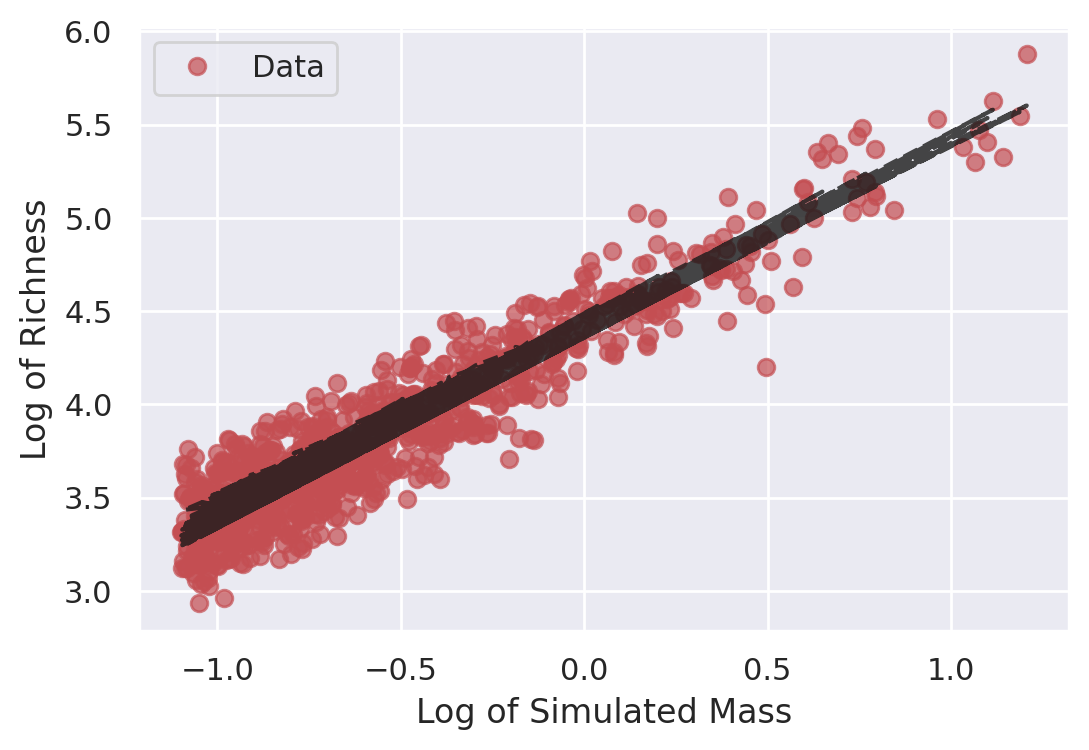

In [11]:
log_msims = np.log(msims/M0)

x1 = log_msims
y1 = ln_lambda

f=lambda x,a,b: a*x + b
fit=curve_fit(f, x1, y1)
xsmooth=np.linspace(np.min(x1), np.max(x1), 1000)
plt.plot(x1,y1,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
plt.xlabel('Log of Simulated Mass')
plt.ylabel('Log of Richness')
plt.legend()

# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of lambda based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

plt.plot(x1, ln_lambda_true, 'k--', label='Truth', alpha = 0.8)

print('Combination of Slope and Y-Intercept:', fit[0])
print('Slope:', fit[0][0])
print('Y-Intercept:', fit[0][1])

Combination of Slope and Y-Intercept: [1.51270629 1.75307065]
Slope: 1.512706292442049
Y-Intercept: 1.7530706477313553


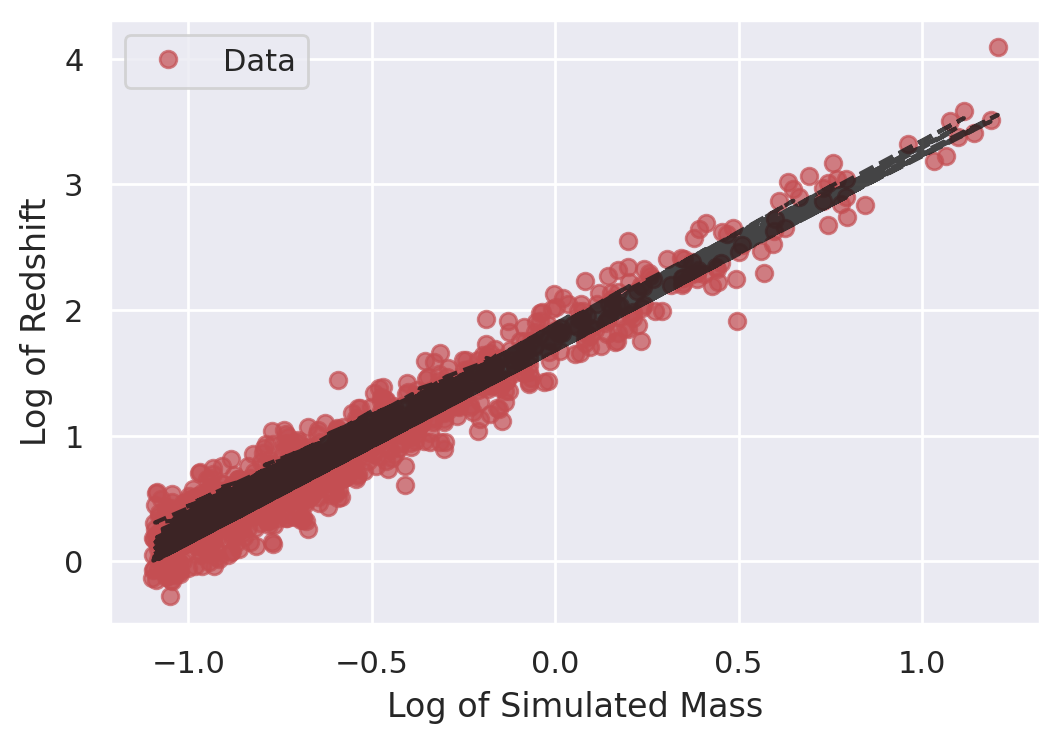

In [12]:
x2 = log_msims
y2 = ln_zeta

f=lambda x,a,b: a*x + b
fit=curve_fit(f, x2, y2)
xsmooth=np.linspace(np.min(x2), np.max(x2), 1000)
plt.plot(x2,y2,'ro',label='Data', alpha = 0.7)
#plt.plot(xsmooth,f(xsmooth,*fit[0]),'b-',linewidth=2,label='Logarithmic Fit')
plt.xlabel('Log of Simulated Mass')
plt.ylabel('Log of Redshift')
plt.legend()


# Unlike the 1-D plot above (simple straight line), this is a vector that
# will create a slope which matches the log value from the previously
# calculated log of zeta based on the true parameter values
# found in (Grandis et al. 2021)

# Meant to compare with the simple 1-D plot above and display
# whether the simulated data is following the trend set by the real parameter values

plt.plot(x1, ln_zeta_true, 'k--', label='Truth', alpha = 0.8)

print('Combination of Slope and Y-Intercept:', fit[0])
print('Slope:', fit[0][0])
print('Y-Intercept:', fit[0][1])

In [13]:
out = dict()
out['z'] = zsims
out['M'] = msims
out['lambda'] = np.exp(ln_lambda)
out['zeta'] = np.exp(ln_zeta)
out['lambda_true'] = np.exp(ln_lambda_true)
out['zeta_true'] = np.exp(ln_zeta_true)

df = pd.DataFrame(out, columns = ['z', 'M', 'lambda', 'zeta', 'lambda_true', 'zeta_true'])
print(df)

#df.to_csv('fake_data_Jun21.csv', index=False)
# pd.DataFrame.to_csv('fake_data_Jun21.csv')

            z             M      lambda      zeta  lambda_true  zeta_true
0    0.364491  2.645752e+14   92.376489  6.226127    71.333465   4.704852
1    0.212223  1.611418e+14   40.527047  1.983667    42.008879   2.116851
2    0.421458  1.354196e+14   34.889183  1.737735    36.360536   1.709244
3    0.568691  2.378565e+14   54.115075  3.424753    66.192795   4.218473
4    0.348993  3.236158e+14  124.412027  7.312194    87.386161   6.382753
..        ...           ...         ...       ...          ...        ...
995  0.138144  1.502575e+14   38.221893  2.058421    38.695692   1.868809
996  0.258536  1.005528e+14   23.576876  0.944123    26.150699   1.038485
997  0.841421  2.764279e+14   92.302664  5.408422    80.809178   5.720953
998  0.328834  1.833976e+14   52.827366  2.589577    48.806451   2.657228
999  0.104172  3.257319e+14  100.127655  9.331435    84.788692   6.077262

[1000 rows x 6 columns]


In [14]:
df0 = df.copy()

display(df0)

,z,M,lambda,zeta,lambda_true,zeta_true
0,0.364491,2.645752e+14,92.376489,6.226127,71.333465,4.704852
1,0.212223,1.611418e+14,40.527047,1.983667,42.008879,2.116851
2,0.421458,1.354196e+14,34.889183,1.737735,36.360536,1.709244
3,0.568691,2.378565e+14,54.115075,3.424753,66.192795,4.218473
4,0.348993,3.236158e+14,124.412027,7.312194,87.386161,6.382753
...,...,...,...,...,...,...
995,0.138144,1.502575e+14,38.221893,2.058421,38.695692,1.868809
996,0.258536,1.005528e+14,23.576876,0.944123,26.150699,1.038485
997,0.841421,2.764279e+14,92.302664,5.408422,80.809178,5.720953
998,0.328834,1.833976e+14,52.827366,2.589577,48.806451,2.657228


In [15]:
zeta = df0.zeta.to_numpy()
zetacut = zeta > 5
df = df0.loc[zetacut].copy()

display(df)

,z,M,lambda,zeta,lambda_true,zeta_true
0,0.364491,2.645752e+14,92.376489,6.226127,71.333465,4.704852
4,0.348993,3.236158e+14,124.412027,7.312194,87.386161,6.382753
5,0.198703,6.228191e+14,152.818634,17.554636,166.480172,16.787285
10,0.230052,5.427773e+14,120.157734,12.467760,145.367806,13.696550
11,0.213267,4.927013e+14,66.726672,6.793262,131.368732,11.758858
...,...,...,...,...,...,...
985,0.404843,3.660485e+14,148.276201,12.789433,99.987144,7.823122
988,0.664600,2.758144e+14,68.511343,6.457091,78.243897,5.433775
992,0.495280,3.463688e+14,151.931930,9.671364,95.928944,7.361448
997,0.841421,2.764279e+14,92.302664,5.408422,80.809178,5.720953


In [16]:
df.to_csv(r'C:\MuStar_Project\mustar-summar-project\simple_model\fake_data_Jun21.csv', index=False)

# Creating an MCMC Model

Using the Simple Model Likelihood in order to see how accurate the predicted MCMC values are from the known true values

In [17]:
SZ_Priors = {'A_sze':[5.24, 0.85], 'B_sze':[1.534, 0.100],'C_sze':[0.465, 0.407],
             'scatter_sze':[0.161, 0.080]}

sz_theta_values = ['A_sze', 'B_sze', 'C_sze', 'scatter_sze']

Lambda_Priors = {'A_lambda':[76.9, 8.2], 'B_lambda':[1.020, 0.080],'C_lambda':[0.23, 0.16],
             'scatter_lambda':[0.23, 0.16]}

lambda_theta_values = ['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']

In [18]:
display(df)

,z,M,lambda,zeta,lambda_true,zeta_true
0,0.364491,2.645752e+14,92.376489,6.226127,71.333465,4.704852
4,0.348993,3.236158e+14,124.412027,7.312194,87.386161,6.382753
5,0.198703,6.228191e+14,152.818634,17.554636,166.480172,16.787285
10,0.230052,5.427773e+14,120.157734,12.467760,145.367806,13.696550
11,0.213267,4.927013e+14,66.726672,6.793262,131.368732,11.758858
...,...,...,...,...,...,...
985,0.404843,3.660485e+14,148.276201,12.789433,99.987144,7.823122
988,0.664600,2.758144e+14,68.511343,6.457091,78.243897,5.433775
992,0.495280,3.463688e+14,151.931930,9.671364,95.928944,7.361448
997,0.841421,2.764279e+14,92.302664,5.408422,80.809178,5.720953


In [19]:
ix = np.where((np.array(df['lambda']))>5)[0] # take 100 points
Np = ix.size

yerr = 0.05*np.ones_like(zsims)

redshift = (np.array(df['z']))[ix]
print("This is the redshift:", redshift)
sz_signal = (np.array(df['zeta']))[ix]
print("This is the sz_signal:", sz_signal)
_lambda = (np.array(df['lambda']))[ix]
print("This is the _lambda:", _lambda)
_lambda_error = (np.array(yerr))[ix]
print("This is the _lambda_error:", _lambda_error)
mass = np.array(df['M'])[ix]
print("This is the mass:", mass)

This is the redshift: [0.36449059 0.34899348 0.19870285 0.23005178 0.2132671  0.93142281
 0.16230056 0.12039734 0.1182469  0.83872471 0.21624013 0.11530444
 0.17968637 0.84190565 0.3250209  0.97973423 0.37903846 0.4669763
 0.29859241 0.18227998 0.3244319  0.25044452 0.36891678 0.56865134
 0.23426108 0.10959387 0.54922878 0.64041268 0.16409622 0.13848226
 0.29792279 0.16594369 0.1642245  0.31174101 0.13942242 0.13067668
 0.62537996 0.76948781 0.45350604 0.49205659 0.15701394 0.57797716
 0.11843307 0.28885962 0.40382163 0.15609348 0.32943208 0.58831869
 0.11203166 0.30724373 0.20912417 0.40836679 0.44425168 0.16308711
 0.83524936 0.18699602 0.44346279 0.38087219 0.36074368 0.11514018
 0.17590519 0.2572482  0.15679213 0.63091533 0.40484263 0.16528722
 0.18116973 0.14794677 0.44624664 0.53174289 0.15942385 0.15549
 0.13125494 0.63985078 0.19071295 0.64981249 0.44178461 0.18637139
 0.21813474 0.32158394 0.31871565 0.17379853 0.34953994 0.85747105
 0.25633997 0.50349291 0.30128497 0.6380303 

In [20]:
# for a given cluster, i.e. a vector (lbd_hat_i, chisi_i, z_i)
# ix = np.arange(len(lambda_chisq))[lambda_chisq>0][np.argmin(sz_signal[lambda_chisq>0])]
ix = np.arange(len(np.array(df['lambda'])))[(np.array(df['lambda']))>0][np.argmax(np.array(df['lambda'])[np.array(df['lambda'])>0])]

redshift_i = (np.array(df['z']))[ix]
print("This is the redshift_i:", redshift_i)
sz_signal_i = (np.array(df['zeta']))[ix]
print("This is the sz_signal_i:", sz_signal_i)
_lambda_i = (np.array(df['lambda']))[ix]
print("This is the _lambda_i:", _lambda_i)
_lambda_error_i = (np.array(yerr))[ix]
print("This is the _lambda_error_i:", _lambda_error_i)

This is the redshift_i: 0.2091241682297576
This is the sz_signal_i: 59.92736821019007
This is the _lambda_i: 357.17182648339656
This is the _lambda_error_i: 0.05


In [21]:
#x1 = np.array([df['M'], df['z']])
#print("This is the combined x1 array of mass and redshift:", x1)
x = np.vstack([mass, redshift])
print("This is the combined x vector of mass and redshift:", x)
y = np.vstack([_lambda, sz_signal])
print("This is the combined y vector of lambda and zeta:", y)

This is the combined x vector of mass and redshift: [[2.64575213e+14 3.23615833e+14 6.22819054e+14 5.42777337e+14
  4.92701346e+14 3.10987235e+14 3.27121313e+14 6.62080529e+14
  4.23574693e+14 2.99174094e+14 2.48057681e+14 2.50254524e+14
  4.99397366e+14 3.21626163e+14 2.68083400e+14 2.48734955e+14
  2.80480883e+14 4.42781605e+14 3.19291711e+14 3.25452932e+14
  3.58289835e+14 3.20699179e+14 5.65670558e+14 4.86936710e+14
  3.55955221e+14 3.91374441e+14 2.89713352e+14 3.55491647e+14
  3.67936846e+14 6.63273455e+14 3.20451385e+14 2.72499953e+14
  4.25668114e+14 6.53643438e+14 3.03579220e+14 4.06614386e+14
  2.94213187e+14 2.46079773e+14 3.45096053e+14 3.05045546e+14
  3.03828933e+14 2.64003078e+14 4.66302017e+14 3.78690484e+14
  3.93279041e+14 4.79096124e+14 3.43916312e+14 3.87074593e+14
  2.72580202e+14 4.60025196e+14 1.00218572e+15 4.25118607e+14
  3.50187959e+14 6.22272345e+14 2.97547688e+14 4.64391556e+14
  3.47433144e+14 3.55631719e+14 3.50150951e+14 4.35855572e+14
  6.97925390e+14 3

In [22]:
eps = 1e-9
lbd = _lambda[0]
zeta = sz_signal[0]

print("This is the first value of lambda:", lbd)
print("This is the first value of zeta:", zeta)

theta = [5.24, 1.534, 0.465, 0.161, 76.9, 1.02, 0.29, 0.16, 0.8]

This is the first value of lambda: 92.37648938160383
This is the first value of zeta: 6.226127166143933


(array([ 8., 24., 36., 35., 21., 12., 11.,  7.,  2.,  7.]),
 array([14.34089302, 14.40689854, 14.47290406, 14.53890958, 14.6049151 ,
        14.67092062, 14.73692613, 14.80293165, 14.86893717, 14.93494269,
        15.00094821]),
 <BarContainer object of 10 artists>)

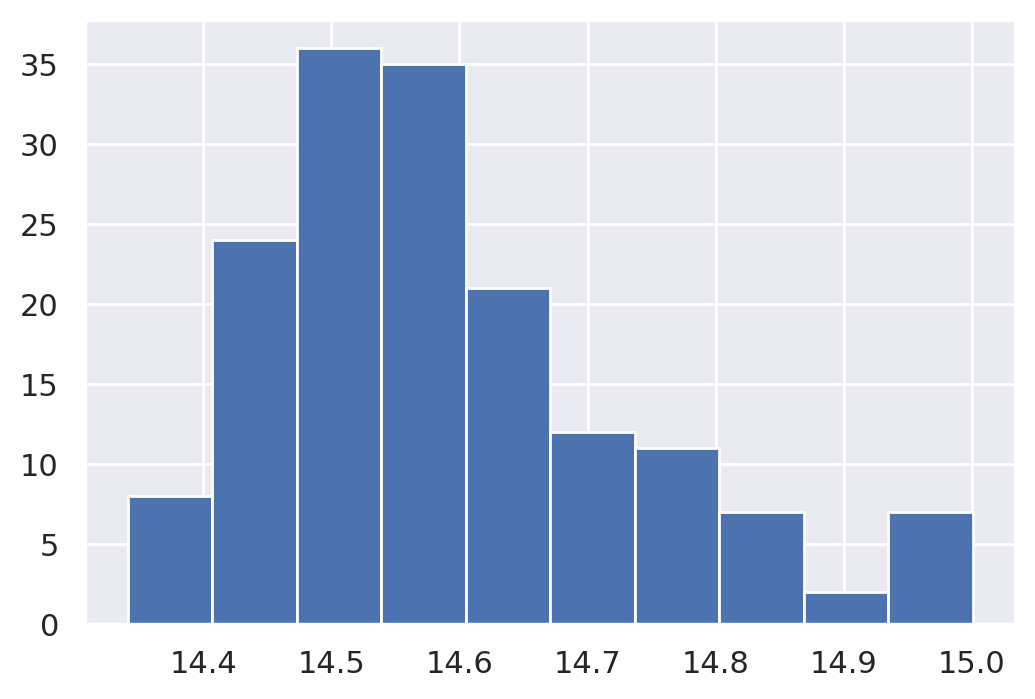

In [23]:
plt.hist(np.log10(df['M'][np.array(df['lambda'])>20]))

In [24]:
# set up integration vectors
# mvec = np.logspace(13.8, 15.5, 75)
# lbdvec = np.linspace(3,1.2*np.max(lambda_chisq),150)
# zetavec = np.linspace(1,1.1*np.max(sz_signal),75)

lbdvec = np.linspace(3, 1.2*np.max(np.array(df['lambda'])), 300)
zetavec = np.linspace(1, 1.1*np.max(np.array(df['zeta'])), 150)

print('Vector size')
print(lbdvec.size)
print(zetavec.size)

Vector size
300
150


In [25]:
zvec = np.linspace(np.min(np.array(df['z'])), np.max(np.array(df['z'])), 100)
#zvec = np.linspace(np.min(redshift), np.max(redshift), 100)
## zzv, mm = np.meshgrid(zvec, mvec)
zzv= np.meshgrid(zvec)
from scipy import interpolate

In [26]:
def slice_array(y,alpha=1e-2):
    cy = np.cumsum(y/np.sum(y),axis=0)
    ilo,iup = np.interp([alpha,1-alpha],cy,np.arange(len(y))).astype(int)+(0,2)
    return ilo, iup

In [27]:
def prob_chisi(zeta, sz_signal, eps=1e-12):
    res = np.exp(-(sz_signal-np.sqrt(zeta**2+2))**2/2.)/np.sqrt(2*np.pi)
    return res#np.where(res<eps,0.,res)

def gaussian(x,mu,std):
    return np.exp(-(x-mu)**2/std**2/2.)/np.sqrt(2*np.pi*std**2)

def prob_lbd_hat(lbd, _lambda , yerr, eps=1e-12):
    res = gaussian(lbd, _lambda, yerr)
    return res#np.where(res<eps,0.,res)

In [28]:
alpha = 0.1

prob_lbd_hat_vec = np.array([prob_lbd_hat(lbdvec, _lambda_i, _lambda_error_i)
                             for _lambda_i, _lambda_error_i in zip(_lambda, _lambda_error)])
print(prob_lbd_hat_vec.shape)
print("This is prob_lbd_hat_vec:", prob_lbd_hat_vec)

prob_chisi_vec = np.array([prob_chisi(zetavec, sz_signal_i) for sz_signal_i in sz_signal])
print(prob_chisi_vec.shape)
print("This is prob_chisi_vec:", prob_chisi_vec)


lbd_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_lbd_hat_vec])
print(lbd_indices_vec.shape)
print("This is lbd_indices_vec:", lbd_indices_vec)

zeta_indices_vec = np.array([slice_array(pi, alpha=alpha) for pi in prob_chisi_vec])
print(zeta_indices_vec.shape)
print("This is zeta_indices_vec:", zeta_indices_vec)

(163, 300)
This is prob_lbd_hat_vec: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(163, 150)
This is prob_chisi_vec: [[1.64152514e-05 5.63085840e-05 2.14349300e-04 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.90842315e-08 3.22318656e-07 1.75663738e-06 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.72657487e-55 1.46503500e-53 2.35516668e-51 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [8.19470514e-15 7.45766645e-14 8.86211617e-13 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.63459566e-04 1.26114878e-03 3.66415789e-03 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.14952697e-13 9.50122422e-13 1.00910087e-11 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(163, 2)
This is lbd_indices_vec: [[ 62  64]
 [ 84  86]
 [104 106]
 [ 81  83]
 [ 44  46]
 [ 57  59]
 [ 65  67]
 [148 150]
 [ 78  80]
 [ 74  76]
 [ 52  54]
 [ 51  53]
 [ 80 

In [29]:
from scipy.integrate import simps

# given: mvec, lbdvec and zetavec

zz, ll = np.meshgrid(zetavec, lbdvec, indexing='ij')

def log_likelihood_vec2(theta, indices, eps=1e-9):
    # defining variables
    probs = []
    for ix in indices:
        probs.append(_log_likelihood2(theta, ix))
    p = np.array(probs)/np.sum(probs)
    log_p = np.log(p)
    log_p = np.where(np.isnan(log_p), -np.inf, log_p)
    return np.sum(log_p)

In [30]:
def _log_likelihood2(theta, ix):
    # unfolding theta
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    redshift_i = redshift[ix]
    print("This is redshift:", redshift_i)
    p_chisi = prob_chisi_vec[ix]
    print("This is p_chisi:", p_chisi)
    p_lbd_hat = prob_lbd_hat_vec[ix]
    print("This is p_lbd_hat:", p_lbd_hat)
    llo, lup = list(lbd_indices_vec[ix])
    print("This is the list of lbd_indices_vec[ix]:", lbd_indices_vec[ix])
    clo, cup = list(zeta_indices_vec[ix])
    print("This is the list of zeta_indices_vec[ix]:", zeta_indices_vec[ix])
    
    print("This is llo:", llo)
    print("This is lup:", lup)
    
    print("This is clo:", clo)
    print("This is cup:", cup)
    #halo_mass_func = hmf_vector[ix]

    # calling predictions;
    ln_lbd_pred = ln_lbd_given_M([A_lambda, B_lambda, C_lambda, scatter_lambda], mass, redshift_i)
    print("This is ln_lbd_pred before lup,llo,cup,clo:", ln_lbd_pred)
    ln_zeta_pred= ln_zeta_given_M([A_sze, B_sze, C_sze, scatter_sze], mass, redshift_i)
    print("This is ln_zeta_pred before lup,llo,cup,clo:", ln_zeta_pred)
    
    #hmf = np.tile(halo_mass_func, (int(lup-llo), int(cup-clo), 1)).T
    ln_lbd_pred = np.tile(ln_lbd_pred, (int(lup-llo), int(cup-clo), 1)).T
    print("This is ln_lbd_pred after lup,llo,cup,clo:", ln_lbd_pred)
    ln_zeta_pred = np.tile(ln_zeta_pred, (int(lup-llo), int(cup-clo), 1)).T
    print("This is ln_zeta_pred after lup,llo,cup,clo:", ln_zeta_pred)
    
    # compute dn_dlbd_dzeta_integrand
    # Now p_lbd_zeta instead of p_total_m = compute_dn_dlbd_dzeta_vec2
    p_lbd_zeta = compute_dn_dlbd_dzeta_vec2(_lambda_i, _lambda_error_i, sz_signal_i,
                                           scatter_lambda, scatter_sze, rho,
                                           ll[clo:cup,llo:lup],zz[clo:cup,llo:lup],
                                           ln_lbd_pred, ln_zeta_pred)
    
    print("This is p_lbd_zeta:", p_lbd_zeta)
    
    # integrate over M
    # Comment out integeration!
    # p_lbd_zeta = np.trapz(p_total_m, x=mvec, axis=0)

    # integrate over zeta
    p_chisi = np.tile(p_chisi[clo:cup], (int(lup-llo), 1)).T
    print("This is p_chisi:", p_chisi)
    
    p_lbd = np.trapz(p_lbd_zeta*p_chisi, x=zetavec[clo:cup], axis=0)
    print("This is p_lbd after trapezoidal transformation:", p_lbd)

    # integrate over lambda
    p = np.trapz(p_lbd*p_lbd_hat[llo:lup], x=lbdvec[llo:lup], axis=0)
    print("This is p after trapezoidal transformation:", p)
    return p

In [31]:
def compute_dn_dlbd_dzeta_vec2(_lambda_i, _lambda_error_i, sz_signal_i, scatter_lambda, scatter_sze, rho,
                               lvec, zvec, ln_lbd_pred, ln_zeta_pred, eps = 1e-9):
    
    # converting std to normal distribution
    s_zeta = logNormal_variance(ln_zeta_pred, scatter_sze)
    s_lambda = logNormal_variance(ln_lbd_pred, scatter_lambda)
    s_zeta_inv = np.where(scatter_sze<=s_zeta, -np.inf, 1/s_zeta)
    s_lambda_inv = np.where(s_lambda<=eps, -np.inf, 1/s_lambda)
    
    cov = (scatter_lambda)**(2)*(scatter_sze)**(2)*(1-rho**2)
    additional_cov = (-0.5)*np.log(np.pi*cov**2)
    
    # avoid error messages
    rho_inv = (1-rho**2)
    rho_inv = np.where(rho_inv<=eps, -np.inf, 1/rho_inv)
    
    # defining standardized variables
    #lbd_std1 = (np.log(lvec) - (ln_lbd_pred))
    #lbd_std = lbd_std1.dot(s_lambda_inv)
    #zeta_std1 = (np.log(zvec)- (ln_zeta_pred))
    #zeta_std = zeta_std1.dot(s_zeta_inv)
    
    lbd_std = (np.log(lvec) - (ln_lbd_pred))*s_lambda_inv
    zeta_std = (np.log(zvec)- (ln_zeta_pred))*s_zeta_inv
    np.seterr(invalid='ignore')

    # lbd_likelihood
    lp_lbd  = (-rho_inv*lbd_std**2)/2

    # zeta likelihood
    lp_zeta = (-rho_inv*zeta_std**2)/2

    # corr likelihod
    lp_corr = rho*rho_inv*lbd_std*zeta_std

    lp_total_m = lp_lbd + lp_zeta + lp_corr + additional_cov
    
    p_total_m = (np.exp(lp_total_m))/(lvec*zvec)
    
    return p_total_m

In [32]:
rho = theta[-1]
scatter_sze = theta[3]
scatter_lambda = theta[7]


def set_gaussian_prior(param, mu, sigma):
    return -0.5*((param - mu)/(sigma))**2

# Setting SZE priors
def set_prior_sze(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_sze', 'B_sze', 'C_sze', 'scatter_sze']):
        mean, error = SZ_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

# Setting Lambda priors
def set_prior_lambda(theta_values):
    lp = 0.
    rhomin = 0.
    rhomax = 1.
    
    for i, prior_name in enumerate(['A_lambda', 'B_lambda', 'C_lambda', 'scatter_lambda']):
        mean, error = Lambda_Priors[prior_name]
        param = theta_values[i]
        result = set_gaussian_prior(param, mean, error)
        lp += np.where(np.abs(result)>9., -np.inf, result)
        # outside a range of six sigmas (six standard deviations)
       
    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if (theta_values[-1] > 0) else -np.inf
    return lp

def logprior(theta):
    lp = 0
    
    A_lambda, B_lambda, C_lambda, scatter_lambda = theta[4:8]
    A_sze, B_sze, C_sze, scatter_sze = theta[:4]
    rho = theta[-1]
    
    lp_lambda = set_prior_lambda([A_lambda, B_lambda, C_lambda, scatter_lambda])
    lp_sze = set_prior_sze([A_sze, B_sze, C_sze, scatter_sze])
    
    lp = 0. if ((rho > 0) and (rho < 1)) else -np.inf
    return lp + lp_lambda + lp_sze

In [33]:
logprior(theta)

0.0

In [34]:
def logposterior(theta, indices):
    lp = logprior(theta)
    
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf
    
    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + log_likelihood_vec2(theta, indices, eps=1e-9)

In [35]:
#set_prior_sze([5.24, 1.534, 0.465, 0.161])

In [36]:
Nburnin = 600 # number of burn-in samples
Nsamples = 1800 # number of final posterior samples
walkers = 100
ndims = len(theta)
guess = (np.array(theta)[:, np.newaxis]*(1.+0.01*np.random.normal(size=(ndims,walkers)))).T

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
sel = np.arange(len(redshift))#[:100]
sel = np.random.randint(len(redshift), size=100, dtype=int)
argslist = [sel]


def is_broadcastable(shp1, shp2):
    for a, b in zip(shp1[::-1], shp2[::-1]):
        if a == 1 or b == 1 or a == b:
            pass
        else:
            return False
    return True

is_broadcastable((2,0),(1000,2,2))

False

In [37]:
logposterior(theta, sel)

This is redshift: 0.4591741869305499
This is p_chisi: [3.05974715e-076 5.69921633e-074 2.29289233e-071 1.40335504e-068
 1.05584125e-065 8.57735451e-063 6.93875371e-060 5.30539529e-057
 3.70303047e-054 2.30366601e-051 1.25594336e-048 5.92785081e-046
 2.40032044e-043 8.28167513e-041 2.42194962e-038 5.97905484e-036
 1.24198099e-033 2.16514485e-031 3.16109303e-029 3.85851704e-027
 3.93206627e-025 3.34138000e-023 2.36540382e-021 1.39378374e-019
 6.83103734e-018 2.78300561e-016 9.41996875e-015 2.64786142e-013
 6.17845070e-012 1.19633348e-010 1.92168152e-009 2.56006414e-008
 2.82785889e-007 2.58946942e-006 1.96529914e-005 1.23605748e-004
 6.44133093e-004 2.78087136e-003 9.94492914e-003 2.94571166e-002
 7.22608797e-002 1.46791672e-001 2.46915849e-001 3.43885017e-001
 3.96519393e-001 3.78508094e-001 2.99102736e-001 1.95648723e-001
 1.05931185e-001 4.74724059e-002 1.76080455e-002 5.40526278e-003
 1.37322819e-003 2.88718387e-004 5.02341006e-005 7.23273950e-006
 8.61738351e-007 8.49582588e-008 6.9

ValueError: operands could not be broadcast together with shapes (7,1,1) (162,8,2) 

In [ ]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood_vec2(*args)
initial = theta + 0.1 * np.random.randn(9)
soln = minimize(nll, initial, args=sel)
albd, blbd, clbd, slbd, rho = soln.x[4:]

print("Maximum likelihood estimates:")
print("Albd = {0:.3f}".format(albd))
print("Blbd = {0:.3f}".format(blbd))
print("Clbd = {0:.3f}".format(clbd))
print("Scatter_lbd = {0:.3f}".format(slbd))
print("rho: {0:.3f}".format(rho))

In [ ]:
theta

In [ ]:
soln.x[-1]

In [ ]:
import time
from multiprocessing import Pool
with Pool(processes = 16) as pool:
    sampler = emcee.EnsembleSampler(walkers, ndims, logposterior,args=argslist, pool=pool)
    start = time.time()
    sampler.run_mcmc(guess, Nsamples+Nburnin, progress=True)
    end = time.time()
    multi_time = end - start
    serial_time = (1.5)*(3600)
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))
    print("{0:.1f} times faster than serial".format(serial_time / multi_time))